# GENTRL MOSES Benchmark

In [3]:
import pandas as pd
import gentrl
import torch
from torch.utils.data import DataLoader
from moses.utils import CharVocab
import matplotlib.pyplot as plt
import numpy as np

RDKit WARNING: [09:02:23] Enabling RDKit 2019.09.3 jupyter extensions


## Pretraining

In [31]:
dataset_path = "./data/moses_qed_props.csv.gz"
df = pd.read_csv(dataset_path)
df

,SMILES,MW,ALOGP,HBD,HBA,PSA,ROTB,AROM,ALERTS
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,0.313256,0.646251,0.250,0.230769,0.422809,0.3,0.333333,0.000000
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,0.427567,0.833384,0.000,0.230769,0.213656,0.4,0.333333,0.000000
2,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,0.867736,0.702549,0.375,0.461538,0.443971,0.6,0.333333,0.166667
3,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,0.042298,0.290565,0.250,0.384615,0.495303,0.3,0.333333,0.000000
4,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,0.216869,0.566450,0.250,0.307692,0.338983,0.3,0.166667,0.000000
...,...,...,...,...,...,...,...,...,...
1584658,N#Cc1c(Br)cnc(N)c1Br,0.269068,0.680942,0.125,0.230769,0.303632,0.0,0.166667,0.000000
1584659,COC(=O)c1cc(CNC(=O)OC(C)(C)C)ccc1C,0.293243,0.749072,0.125,0.307692,0.312978,0.3,0.166667,0.166667
1584660,NC(=O)c1ccc2ccccc2c1Br,0.000780,0.739470,0.125,0.076923,0.208668,0.1,0.333333,0.000000
1584661,CC(=O)Nc1cccc(-c2nc3cc(C)ccc3[nH]c2=O)c1,0.433168,0.753695,0.250,0.230769,0.362470,0.2,0.500000,0.000000


In [ ]:
save_path = "./saved_model/"
vocab = CharVocab.from_data(df['SMILES'])
torch.cuda.set_device(0)

enc = gentrl.RNNEncoder(vocab, latent_size=50)
dec = gentrl.DilConvDecoder(vocab, latent_input_size=50, split_len=100)
model = gentrl.GENTRL(enc, dec, 50 * [("c", 20)], [("c", 20)], beta=0.001)
model.cuda()
props = ["MW", "ALOGP", "HBD", "HBA", "PSA", "ROTB", "AROM", "ALERTS"]
source = {
    "path": dataset_path,
    "smiles": "SMILES",
    "prob": 1,
}
for prop in props:
    source[prop] = prop

md = gentrl.MolecularDataset(sources=[source], props=props)

train_loader = DataLoader(
    md, batch_size=50, shuffle=True, num_workers=1, drop_last=True
)
model.train_as_vaelp(train_loader, lr=1e-4, num_epochs=5, save_path=save_path)
model.save(save_path)

## Training statistics
This was the last output from the training stats:

loss: -0.4258;
rec: -0.06856;
kl: -223.4;
log_p_y_by_z: 2.709;
log_p_z_by_y: -303.8;

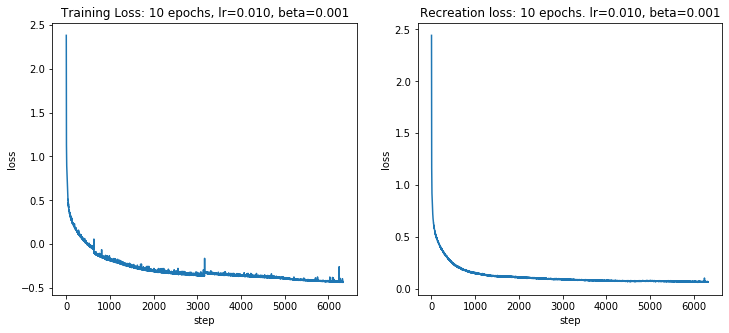

In [2]:
from utils import get_log_data, plot_log
training_log_path = "./models/moses/logs/moses_qed_props.stdout"
loss_arr, rec_arr = get_log_data(training_log_path)
plot_log(loss_arr, rec_arr)


## MOSES Benchmark

In [5]:
import pickle
import pandas as pd
metrics_folder = "./moses_sampling/metrics"
for i in range(1,11):
    metrics = pickle.load( open(metrics_folder + "/metrics_"+str(i)+".pkl", "rb" ) )
    df_next = pd.DataFrame(metrics, index=[0])
    if i >= 2:
        df = df.append(df_next, ignore_index=True)
    else:
        df = df_next

df

,valid,unique@1000,unique@10000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,FCD/TestSF,SNN/TestSF,Frag/TestSF,Scaf/TestSF,IntDiv,IntDiv2,Filters,logP,SA,QED,weight,Novelty
0,1.0,1.0,1.0000,4.827928,0.431663,0.943983,0.673205,5.710529,0.417006,0.939374,0.117768,0.864068,0.858433,0.877735,0.272419,0.460427,0.035744,7.784631,0.996436
1,1.0,1.0,1.0000,4.843644,0.430894,0.941413,0.646162,5.740561,0.416559,0.936770,0.130890,0.864359,0.858718,0.876781,0.277449,0.463068,0.035339,7.803328,0.996604
2,1.0,1.0,0.9999,4.906141,0.431297,0.941016,0.675798,5.805024,0.416441,0.936456,0.123929,0.864188,0.858540,0.874950,0.263728,0.465305,0.033929,7.638621,0.996468
3,1.0,1.0,0.9999,4.910907,0.430401,0.942771,0.634997,5.796083,0.415803,0.938369,0.124675,0.864570,0.858919,0.875500,0.265838,0.464473,0.034129,7.329588,0.996367
4,1.0,1.0,0.9999,4.855972,0.431171,0.943105,0.658733,5.749218,0.416563,0.938637,0.105395,0.864335,0.858710,0.877037,0.267680,0.455282,0.034208,7.554601,0.996534
5,1.0,1.0,0.9999,4.852010,0.431207,0.943386,0.664022,5.745499,0.415593,0.939103,0.106140,0.864406,0.858766,0.876048,0.273353,0.466305,0.033821,7.832484,0.996840
6,1.0,1.0,0.9999,4.808840,0.430830,0.942466,0.649138,5.695265,0.416570,0.938072,0.120666,0.864395,0.858762,0.875317,0.265071,0.460399,0.033122,7.452676,0.996533
7,1.0,1.0,0.9999,4.877361,0.430638,0.942093,0.659698,5.753744,0.416187,0.937470,0.120524,0.864204,0.858568,0.877473,0.271215,0.460558,0.033983,7.560123,0.995669
8,1.0,1.0,1.0000,4.863342,0.431131,0.941516,0.667957,5.765589,0.415882,0.937137,0.110631,0.864491,0.858840,0.878982,0.268869,0.466708,0.034973,7.791232,0.996438
9,1.0,1.0,1.0000,4.845524,0.430445,0.943636,0.658869,5.731746,0.415785,0.939076,0.122792,0.864615,0.859004,0.878839,0.266314,0.465233,0.034447,7.621000,0.996572


In [6]:
df.agg(["mean", "std"]).transpose()

,mean,std
valid,1.000000,0.000000
unique@1000,1.000000,0.000000
unique@10000,0.999940,0.000052
FCD/Test,4.859167,0.032023
SNN/Test,0.430968,0.000401
Frag/Test,0.942539,0.001012
Scaf/Test,0.658858,0.012596
FCD/TestSF,5.749326,0.033995
SNN/TestSF,0.416239,0.000458
Frag/TestSF,0.938047,0.001039


For some reason the QED is very small here, but not when running QED function on the SMILES themselves:

In [29]:
import seaborn as sns
from moses.metrics import QED, SA, logP, weight
from rdkit.Chem import MolFromSmiles
smiles_path = "./moses_sampling/sampled_smiles/sampled_smiles_2.csv"
df = pd.read_csv(smiles_path, names=['smiles'])
df['logP'] = df['smiles'].apply(lambda x: logP(MolFromSmiles(x)))
df['SA'] = df['smiles'].apply(lambda x: SA(MolFromSmiles(x)))
df['QED'] = df['smiles'].apply(lambda x: QED(MolFromSmiles(x)))
df['weight'] = df['smiles'].apply(lambda x: weight(MolFromSmiles(x)))

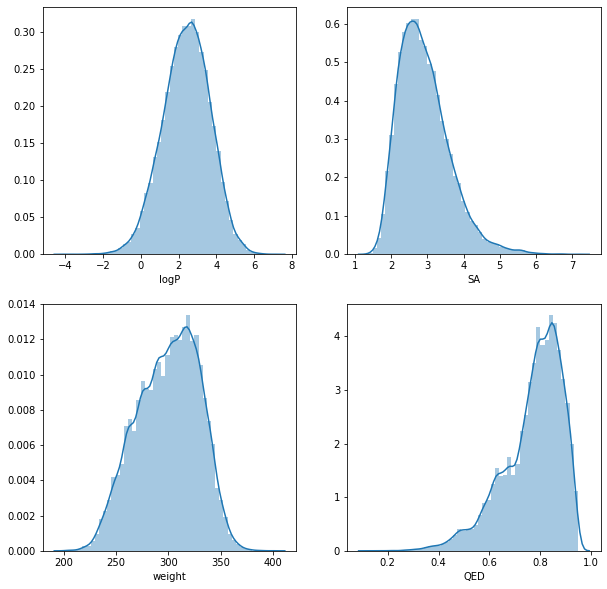

In [30]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
sns.distplot(df['logP'])
plt.subplot(2, 2, 2)
sns.distplot(df['SA'])
plt.subplot(2, 2, 3)
sns.distplot(df['weight'])
plt.subplot(2, 2, 4)
sns.distplot(df['QED'])
plt.show()